In [1]:
import warnings

warnings.filterwarnings("ignore")
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))
FORCE = True

# AppVoCAI Dataset Cleaning
---
In the previous section, we analyzed the AppVoCAI dataset, evaluating its validity, completeness, uniqueness, relevance, and adherence to data privacy concerns. This section is about duplicate deleting, language filtering, artifact removing, PII masking, character normalizing, data cleaning. 

Our data cleaning methodology focuses on addressing critical data quality issues that could undermine the integrity of downstream analyses, while preserving the text as close to its original form as possible. By adopting this conservative approach, we tackle key issues without sacrificing the nuance and representativeness of the data, ensuring the models are presented with rich, authentic input.

## Data Cleaning Key Evaluation Questions (KEQs)
---
Although, this data cleaning approach comprises many of the preprocessing techniques commonly found in the literature {cite}`symeonidisComparativeEvaluationPreprocessing2018`, the following data cleaning approach is motivated by three guiding questions.

1. What’s essential to remove, and what can be left intact to preserve meaning?
2. How do we best preserve text richness and nuance?
3. How can the data cleaning process best exploit model strengths towards optimal model performance?

These Key Evaluation Questions (KEQs) crystallized our approach which balances data quality with model sophistication.


### Import Libraries
---

In [2]:
import pandas as pd
from genailab.setup import auto_wire_container
from genailab.infra.service.spark.pool import SparkSessionPool
from genailab.analytics.dqa import DQA
from genailab.core.dtypes import DFType
from genailab.infra.utils.file.fileset import FileFormat
from genailab.flow.dataprep.clean.builder import DataCleaningStageBuilder
from genailab.flow.dataprep.dqa.builder import DataQualityAssessmentStageBuilder
from genailab.asset.dataset.config import DatasetConfig
from genailab.core.flow import PhaseDef, StageDef


# Wire container
container = auto_wire_container()

## Data Cleaning Approach
---
The following describes our data cleaning process and steps, executed in the order listed. We begin with 'safe' techniques that carry minimal risk of compromising downstream cleaning tasks. For instance, UTF-8 encoding can impact the accuracy of language detection algorithms, especially if characters carry language-specific information. Removing special characters may compromise the detection of Personally Identifiable Information (PII) such as URLs and email addresses. As the process progresses, steps carry a greater impact on the data, its expressiveness, and representation.

Our minimalist, task-specific, model-informed, *leave-as-is* data cleaning process unfolds as follows:

1. **Relevance**: Observations containing **non-English text or app names** will be removed to maintain linguistic uniformity within the dataset, which is crucial for consistent language-based analysis. 
2. **Uniqueness**: For duplicate review IDs, our policy for retention is based on review date. Retaining the most recent review prioritizes review recency, timeliness and relevance. Observations containing duplicate review text will be retained to maximize fidelity to customer experience and expression. 
3. **Privacy**: Personally identifiable information (PII) such as URLs, email addresses and phone numbers detected in the previous section are removed from the dataset to ensure adherence to data privacy and minimal information policies.
4. **Validity**: Replace or remove artifacts, patterns, and noise that do not convey meaningful content, and may compromise dataset validity. Remediations include:
    1. **Control Characters**: Remove HTML entities (e.g., `&amp;`, `&#39;`), and non-printable characters from the Unicode and ASCII character sets used to control text flow or hardware devices (e.g., newline, tab, or carriage return). These characters have no analytical value and can interfere with text processing.
    2. **Diacritics and Accents**:  We normalize accented characters (e.g., converting `é` to `e`) to reduce unnecessary text variation, which simplifies analysis without compromising the meaning of the content.
    3. **Elongation**: Elongated words (e.g., "soooo") convey emphasis in informal text, which is valuable for sentiment analysis. We use a threshold approach to limit characters that appear four or more times consecutively to a maximum of three (e.g., "soooo" becomes "sooo"), preserving emphasis while maintaining readability.
    4. **Repetition**: Excess character, sequence, word and phrase repetition is reduced, but not eliminated to perserve artifacts that may signal emphasis.
    5. **Special Characters**: Excessive special characters can indicate SPAM, emotional intensity, or nonsensical content. We apply a threshold: if special characters make up more than 35% of the review text, the review is removed.     
    6. **Trim Whitespace**: We trim excess whitespace from review text.
5. **Non-Informative Reviews**: Reviews that don't match minimum length criteria are removed.


### Data Cleaning Techniques Not Implemented
---
In natural language processing (NLP), text cleaning measures such as lower-casing, contraction and abbreviation expansion, spelling correction, and the removal of emoticons, emojis, and other artifacts are considered standard practice. Given that transformer models are fine-tuned on large user generated content datasets such as the IMDB Movie and SemEval Laptop Reviews dataset, they are highly adept at handling a wide variety of tokens, including emojis, spelling variations, abbreviations and contractions. So, we take a **leave emojis as-is** approach. By leveraging the inherent strengths of transformer - particularly their ability to tokenize subword units and learn from context — we preserve the natural, authentic nature of user-generated content.

## Data Cleaning Pipeline
---
Following our established pipeline construction process, we specify the source and target dataset configurations and obtain an Apache Spark Session to facilitate data processing. 

> Hey Siri, queue the **Data Cleaning** playlist.

In [3]:
# Source Dataset Configuration
source_config = DatasetConfig(
    phase=PhaseDef.DATAPREP,
    stage=StageDef.DQA,
    name="review",
    file_format=FileFormat.PARQUET,
    asset_type="dataset",
    dftype=DFType.SPARK,
)

# Target Dataset Configuration
target_config = DatasetConfig(
    phase=PhaseDef.DATAPREP,
    stage=StageDef.SEMICLEAN,
    name="review",
    file_format=FileFormat.PARQUET,
    asset_type="dataset",
    dftype=DFType.SPARK,
)


In [4]:
# Create builder
cleaning_stage = (
    DataCleaningStageBuilder()
    .clean_non_english()
    .clean_privacy_issues()
    .clean_duplication()
    .clean_invalid_values()
    .clean_elongation(threshold=3, max_elongation=2)
    .clean_special_chars()
    .clean_invalid_characters()
    .clean_excess_special_chars(threshold=0.35)
    .clean_repeated_words(threshold=3, max_repetitions=1)
    .clean_repeated_sequences(length_of_sequence=3, threshold=3, max_repetitions=3)
    .clean_repeated_phrases(length_of_phrase=2, threshold=2, max_repetitions=2)
    .clean_short_reviews(threshold=5)
    .clean_excess_whitespace()
    .build(source_config=source_config, target_config=target_config)
)
# Run the stage
dataset = cleaning_stage.run(force=FORCE)

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).




# ============================================================================== #
#                Semi-Clean Data Stage Tue, 04 Feb 2025 14:53:33                 #
# ============================================================================== #




Task                                    Start       End         Runtime     
----------------------------------------------------------------------------
PartitionTask                           14:53:38    14:53:44    6.26 seconds
DetectOrRepairNonEnglishTask            14:53:44    14:53:44    0.08 seconds
DetectOrRepairNonEnglishTask            14:53:44    14:53:44    0.01 seconds
DetectOrRepairEmailAddressTask          14:53:44    14:53:44    0.11 seconds
DetectOrRepairPhoneNumberTask           14:53:44    14:53:45    0.07 seconds
DetectOrRepairURLTask                   14:53:45    14:53:45    0.09 seconds
DetectOrRepairUniquenessTask            14:53:45    14:53:45    0.03 seconds
DetectOrRepairUniquenessTask            14:53:45    14:53:45    0.03 seconds
DetectOrRepairUniquenessTask            14:53:45    14:53:45    0.03 seconds
DetectOrRepairCategoryAnomalyTask       14:53:45    14:53:45    0.02 seconds
DetectOrRepairRatingAnomalyTask         14:53:45    14:53:45    0.02 second

Processing Partitions: 100%|██████████| 1/1 [08:04<00:00, 484.68s/it]           


ProgressTask                            14:53:46    15:04:59    11.0 minutes and 13.44 seconds


____________________________________________________________________________
Semi-Clean Data Stage                   14:53:33    15:05:02    11.0 minutes and 28.92 seconds


# ============================================================================ #



## Data Quality Verification Pipeline
---
This data quality verification pipeline will assess the degree to which the cleaned dataset meets quality criteria for validity, relevance, completeness, privacy and uniquness. 

In [5]:
# Source Dataset Configuration
source_config = DatasetConfig(
    phase=PhaseDef.DATAPREP,
    stage=StageDef.SEMICLEAN,
    name="review",
    file_format=FileFormat.PARQUET,
    asset_type="dataset",
    dftype=DFType.SPARK,
)

# Target Dataset Configuration
target_config = DatasetConfig(
    phase=PhaseDef.DATAPREP,
    stage=StageDef.DQV,
    name="review",
    file_format=FileFormat.PARQUET,
    asset_type="dataset",
    dftype=DFType.SPARK,
)

In [6]:
# Create builder
builder = DataQualityAssessmentStageBuilder()
dqv_stage = (
    builder
    .detect_non_english()
    .detect_privacy_issues()
    .detect_duplication()
    .detect_invalid_values()
    .detect_elongation(threshold=3, max_elongation=2)
    .detect_special_chars()
    .detect_invalid_characters()
    .detect_excess_special_chars(threshold=0.35)
    .detect_repeated_words(threshold=3, max_repetitions=1)
    .detect_repeated_sequences(threshold=3, max_repetitions=3)
    .detect_repeated_phrases(length_of_phrase=2, threshold=2, max_repetitions=2)
    .detect_short_reviews(threshold=5)
    .detect_excess_whitespace()
    .build(source_config=source_config, target_config=target_config)
)

# Run the stage
dataset = dqv_stage.run(force=FORCE)



# ============================================================================== #
#            Data Quality Assessment Stage Tue, 04 Feb 2025 15:05:05             #
# ============================================================================== #



PartitionTask                           15:05:05    15:05:07    2.22 seconds
DetectOrRepairNonEnglishTask            15:05:07    15:05:07    0.04 seconds
DetectOrRepairNonEnglishTask            15:05:07    15:05:07    0.04 seconds
DetectOrRepairEmailAddressTask          15:05:07    15:05:07    0.01 seconds
DetectOrRepairPhoneNumberTask           15:05:07    15:05:07    0.01 seconds
DetectOrRepairURLTask                   15:05:07    15:05:07    0.01 seconds
DetectOrRepairUniquenessTask            15:05:07    15:05:07    0.1 seconds 
DetectOrRepairUniquenessTask            15:05:07    15:05:07    0.08 seconds
DetectOrRepairUniquenessTask            15:05:07    15:05:08    0.1 seconds 
DetectOrRepairCategoryAnomalyTask       15:05:08    15:05:08    0.07 seconds
DetectOrRepairRatingAnomalyTask         15:05:08    15:05:08    0.05 seconds
DetectOrRepairReviewDateAnomalyTask     15:05:08    15:05:08    0.19 seconds
DetectOrRepairElongationTask            15:05:08    15:05:08    0.02 seconds

Processing Partitions:   5%|▌         | 1/19 [00:55<16:33, 55.17s/it]           


ProgressTask                            15:05:08    15:09:00    3.0 minutes and 51.86 seconds


____________________________________________________________________________
Data Quality Assessment Stage           15:05:05    15:09:02    3.0 minutes and 57.73 seconds


# ============================================================================ #



## Data Quality Verification
---

The Data Quality Analysis is performed in Pandas, so let's get a Pandas version of the dataset.

In [7]:
# Target Dataset
repo = container.io.repo()
target = repo.get(asset_id=dataset.asset_id, dftype=DFType.PANDAS)

,Dimension,Score
0,Completeness,1.000000
1,Validity,0.998227
2,Relevance,1.000000
3,Uniqueness,1.000000
4,Privacy,0.999930


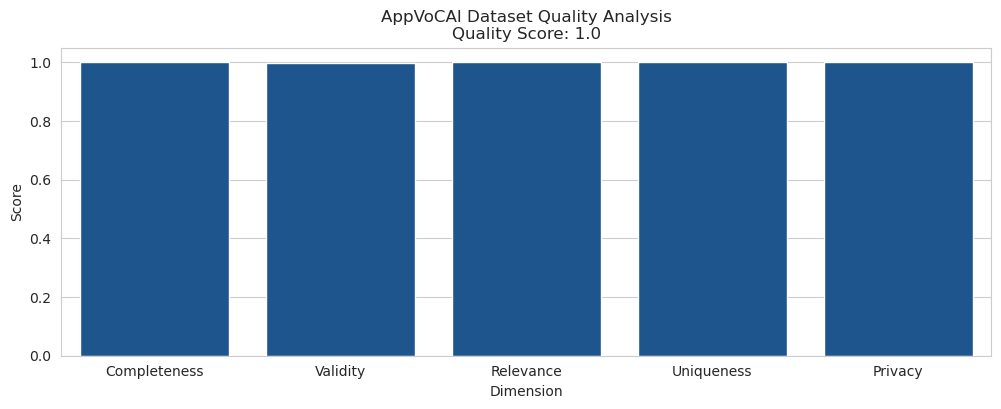

In [8]:
# Execute the Data Quality Verification
dqa = DQA(dataset=target)
dqa.analyze_quality()

### Data Quality Verification Impressions
---
The data quality verification reveals strong performance across key dimensions. Completeness reflects some variation in app category coverage, which will be addressed during pre-training and instance selection. Validity confirms adherence to expected formats and rules, ensuring a high signal-to-noise ratio in the text. Relevance is achieved by filtering out non-English reviews and those too short to provide meaningful information for aspect-based sentiment analysis. The dataset is free from duplication, and high privacy compliance is maintained through the removal of personally identifiable information.

Finally, we approve the dataset, elevating its status from `semiclean` to `clean`, and persisting it to the repository.

In [9]:
_ = cleaning_stage.approve(dataset=target)

In [10]:
# Stop Spark Session
container.spark.session_pool().stop()